[View in Colaboratory](https://colab.research.google.com/github/pmanlukas/colab/blob/master/openapi_classifier.ipynb)

# openAPI spec classifier
This notebook is used to create a first proof of concept on a classifier for openAPI files. The classifier will be based on a neural network based architecture and will be implemented in Tensorflow, SciPy and Keras.

In [1]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0


Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) ...
Setting up python3-software-properties (0.96.24.17) ...
Setting up dbus (1.10.22-1ubuntu1) ...
Setting

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [4]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# Create a folder to use for the project data
!mkdir -p /content/drive/openapi-data/

In [7]:
!ls /content/drive/openapi-data/

glove.6B.zip		 path_labels.csv	   structure_labels.csv
mnist.py		 pickle			   weights.best.hdf5
new_path_labels0518.csv  PoC Classifier Path.odt   wordvector
path_labels0518.csv	 structure_labels0518.csv


In [8]:
!pip install -q keras
!pip install -q graphviz
import keras
import graphviz

Using TensorFlow backend.


In [9]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import os
os.chdir("drive/openapi-data")

In [11]:
!ls

glove.6B.zip		 path_labels.csv	   structure_labels.csv
mnist.py		 pickle			   weights.best.hdf5
new_path_labels0518.csv  PoC Classifier Path.odt   wordvector
path_labels0518.csv	 structure_labels0518.csv


In [0]:
import pickle

In [0]:
training_data = dict()

with open('pickle/specjson210518.pkl', 'rb') as handle:
    training_data = pickle.load(handle)

In [0]:
keys = list(training_data.keys())

In [15]:
training_data[keys[0]]

{'basePath': '/forex-quotes',
 'host': '1forge.com',
 'info': {'contact': {'email': 'contact@1forge.com',
   'name': '1Forge',
   'url': 'http://1forge.com'},
  'description': 'Stock and Forex Data and Realtime Quotes',
  'title': '1Forge Finance APIs',
  'version': '0.0.1',
  'x-apisguru-categories': ['financial'],
  'x-logo': {'backgroundColor': '#24292e',
   'url': 'https://api.apis.guru/v2/cache/logo/http_1forge.com_logo.png'},
  'x-origin': [{'format': 'swagger',
    'url': 'http://1forge.com/openapi.json',
    'version': '2.0'}],
  'x-preferred': True,
  'x-providerName': '1forge.com'},
 'paths': {'/quotes': {'get': {'description': 'Get quotes',
    'externalDocs': {'description': 'Find out more',
     'url': 'http://1forge.com/forex-data-api'},
    'responses': {'200': {'description': 'A list of quotes'}},
    'summary': 'Get quotes for all symbols',
    'tags': ['forex', 'finance', 'quotes']}},
  '/symbols': {'get': {'description': 'Symbol List',
    'externalDocs': {'descripti

In [0]:
from collections import Counter
from datetime import datetime
 
import json
 
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
 
import numpy as np
import pandas as pd

In [17]:
!ls

glove.6B.zip		 path_labels.csv	   structure_labels.csv
mnist.py		 pickle			   weights.best.hdf5
new_path_labels0518.csv  PoC Classifier Path.odt   wordvector
path_labels0518.csv	 structure_labels0518.csv


In [0]:
labelsP = pd.read_csv("new_path_labels0518.csv").values
labelsS  = pd.read_csv("structure_labels0518.csv").values

In [64]:
labelsP



array([['1forge.com', 1],
       ['6-dot-authentiqio.appspot.com', 2],
       ['adafruit.com', 3],
       ...,
       ['zoom.us', 3],
       ['zoomconnect.com', 3],
       ['zuora.com', 3]], dtype=object)

In [20]:
labelsS

array([['1forge.com', 1],
       ['6-dot-authentiqio.appspot.com', 2],
       ['adafruit.com', 3],
       ...,
       ['zoom.us', 5],
       ['zoomconnect.com', 4],
       ['zuora.com', 4]], dtype=object)

## test word embeddings

In [21]:
texts = []   # list of text samples
for spec in training_data:
  strJson = json.dumps(training_data[spec])
  texts.append(strJson)

print(str(len(texts)))

1034


In [24]:
print(type(texts[0]))
print(texts[0])

<class 'str'>
{"swagger": "2.0", "schemes": ["https", "http"], "host": "1forge.com", "basePath": "/forex-quotes", "info": {"contact": {"email": "contact@1forge.com", "name": "1Forge", "url": "http://1forge.com"}, "description": "Stock and Forex Data and Realtime Quotes", "title": "1Forge Finance APIs", "version": "0.0.1", "x-apisguru-categories": ["financial"], "x-logo": {"backgroundColor": "#24292e", "url": "https://api.apis.guru/v2/cache/logo/http_1forge.com_logo.png"}, "x-origin": [{"format": "swagger", "url": "http://1forge.com/openapi.json", "version": "2.0"}], "x-preferred": true, "x-providerName": "1forge.com"}, "produces": ["application/json"], "paths": {"/quotes": {"get": {"description": "Get quotes", "externalDocs": {"description": "Find out more", "url": "http://1forge.com/forex-data-api"}, "responses": {"200": {"description": "A list of quotes"}}, "summary": "Get quotes for all symbols", "tags": ["forex", "finance", "quotes"]}}, "/symbols": {"get": {"description": "Symbol L

In [61]:


labels = labelsStruct  # list of label ids
print(type(labels))
print(labels)

<class 'list'>
[1, 2, 3, 3, 1, 1, 1, 1, 1, 4, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 1, 4, 2, 1, 5, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 1, 1, 3, 4, 2, 5, 3, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 7, 7, 7, 7, 3, 3, 3, 6, 3, 3, 6, 7, 7, 7, 7, 7, 6, 7, 6, 6, 7, 7, 7, 7, 7, 7, 6, 7, 7, 

In [65]:
labelsP = labelsPath  # list of label ids
print(type(labelsP))
print(labelsP)

<class 'list'>
[]


In [27]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

encoder = LabelBinarizer()
encoder.fit(labels)
y_train = encoder.transform(labels)

y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [28]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

encoder = LabelBinarizer()
encoder.fit(labelsP)
yp_train = encoder.transform(labelsP)

yp_train

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [0]:
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

In [0]:
MAX_SEQUENCE_LENGTH = 100000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [31]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(nb_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = y_train #keras.utils.to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

/usr/local/lib/python3.6/dist-packages/keras/preprocessing/text.py:172: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 151535 unique tokens.
Shape of data tensor: (1034, 100000)
Shape of label tensor: (1034, 8)


In [33]:
y_train

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [34]:
embeddings_index = {}
f = open(os.path.join('wordvector', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, LSTM

In [0]:
!pip install -q pydot

In [0]:
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import regularizers
from keras.callbacks import ModelCheckpoint


sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 5, kernel_regularizer=regularizers.l2(0.02), activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)

x = Conv1D(128, 5, kernel_regularizer=regularizers.l2(0.02), activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)

x = Conv1D(128, 5, kernel_regularizer=regularizers.l2(0.02), activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Dropout(0.2)(x)

x = Flatten()(x)

x = Dense(256, kernel_regularizer=regularizers.l2(0.02), activation='relu')(x)
x = Dropout(0.2)(x)

preds = Dense(8, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [0]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [42]:
summary = model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100000)            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100000, 100)       2000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 99996, 128)        64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19999, 128)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19999, 128)        0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 19995, 128)        82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3999, 128)         0         
__________

In [48]:
# happy learning!
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=30,
                    verbose=1,
                    validation_split=0.2, callbacks=callbacks_list)

Train on 662 samples, validate on 166 samples
Epoch 1/30
662/662 [==============================] - 31s 46ms/step - loss: 2.0050 - acc: 0.5151 - val_loss: 1.6796 - val_acc: 0.5120

Epoch 00001: val_acc did not improve from 0.56024
Epoch 2/30
662/662 [==============================] - 30s 46ms/step - loss: 1.5027 - acc: 0.5589 - val_loss: 1.6373 - val_acc: 0.5663

Epoch 00002: val_acc improved from 0.56024 to 0.56627, saving model to weights.best.hdf5
Epoch 3/30
662/662 [==============================] - 30s 46ms/step - loss: 1.4413 - acc: 0.5619 - val_loss: 1.6141 - val_acc: 0.5060

Epoch 00003: val_acc did not improve from 0.56627
Epoch 4/30
662/662 [==============================] - 30s 46ms/step - loss: 1.4432 - acc: 0.5650 - val_loss: 1.6558 - val_acc: 0.5301

Epoch 00004: val_acc did not improve from 0.56627
Epoch 5/30
662/662 [==============================] - 30s 46ms/step - loss: 1.3965 - acc: 0.5755 - val_loss: 1.9916 - val_acc: 0.3735

Epoch 00005: val_acc did not improve fro

662/662 [==============================] - 30s 46ms/step - loss: 1.3909 - acc: 0.5921 - val_loss: 1.7913 - val_acc: 0.4940

Epoch 00007: val_acc did not improve from 0.56627
Epoch 8/30
662/662 [==============================] - 30s 46ms/step - loss: 1.4010 - acc: 0.5785 - val_loss: 1.7518 - val_acc: 0.5060

Epoch 00008: val_acc did not improve from 0.56627
Epoch 9/30
662/662 [==============================] - 30s 46ms/step - loss: 1.3631 - acc: 0.6103 - val_loss: 1.7096 - val_acc: 0.5301

Epoch 00009: val_acc did not improve from 0.56627
Epoch 10/30
662/662 [==============================] - 30s 46ms/step - loss: 1.3748 - acc: 0.5921 - val_loss: 1.9061 - val_acc: 0.4639

Epoch 00010: val_acc did not improve from 0.56627
Epoch 11/30
662/662 [==============================] - 30s 46ms/step - loss: 1.3881 - acc: 0.5876 - val_loss: 1.8978 - val_acc: 0.4518

Epoch 00011: val_acc did not improve from 0.56627
Epoch 12/30
662/662 [==============================] - 30s 46ms/step - loss: 1.3744 

662/662 [==============================] - 30s 46ms/step - loss: 1.3494 - acc: 0.6208 - val_loss: 1.7377 - val_acc: 0.5361

Epoch 00014: val_acc did not improve from 0.56627
Epoch 15/30
662/662 [==============================] - 30s 46ms/step - loss: 1.3064 - acc: 0.6073 - val_loss: 1.6045 - val_acc: 0.5120

Epoch 00015: val_acc did not improve from 0.56627
Epoch 16/30
662/662 [==============================] - 30s 46ms/step - loss: 1.3315 - acc: 0.6042 - val_loss: 1.7227 - val_acc: 0.5602

Epoch 00016: val_acc did not improve from 0.56627
Epoch 17/30
662/662 [==============================] - 30s 46ms/step - loss: 1.3212 - acc: 0.6224 - val_loss: 1.8825 - val_acc: 0.5120

Epoch 00017: val_acc did not improve from 0.56627
Epoch 18/30
662/662 [==============================] - 30s 46ms/step - loss: 1.3063 - acc: 0.6224 - val_loss: 1.6125 - val_acc: 0.5241

Epoch 00018: val_acc did not improve from 0.56627
Epoch 19/30
662/662 [==============================] - 30s 46ms/step - loss: 1.310

662/662 [==============================] - 30s 46ms/step - loss: 1.2958 - acc: 0.6375 - val_loss: 1.6340 - val_acc: 0.5542

Epoch 00021: val_acc did not improve from 0.56627
Epoch 22/30
662/662 [==============================] - 30s 46ms/step - loss: 1.2639 - acc: 0.6329 - val_loss: 1.6580 - val_acc: 0.5422

Epoch 00022: val_acc did not improve from 0.56627
Epoch 23/30
662/662 [==============================] - 30s 46ms/step - loss: 1.2526 - acc: 0.6405 - val_loss: 1.9000 - val_acc: 0.5361

Epoch 00023: val_acc did not improve from 0.56627
Epoch 24/30
662/662 [==============================] - 30s 46ms/step - loss: 1.2821 - acc: 0.6254 - val_loss: 1.8087 - val_acc: 0.5301

Epoch 00024: val_acc did not improve from 0.56627
Epoch 25/30
662/662 [==============================] - 30s 46ms/step - loss: 1.2632 - acc: 0.6299 - val_loss: 1.6982 - val_acc: 0.5361

Epoch 00025: val_acc did not improve from 0.56627
Epoch 26/30
662/662 [==============================] - 30s 45ms/step - loss: 1.256

Epoch 28/30
662/662 [==============================] - 30s 46ms/step - loss: 1.2740 - acc: 0.6254 - val_loss: 1.6106 - val_acc: 0.5723

Epoch 00028: val_acc did not improve from 0.57831
Epoch 29/30
662/662 [==============================] - 30s 45ms/step - loss: 1.2045 - acc: 0.6616 - val_loss: 1.6897 - val_acc: 0.5181

Epoch 00029: val_acc did not improve from 0.57831
Epoch 30/30
662/662 [==============================] - 30s 46ms/step - loss: 1.2920 - acc: 0.6284 - val_loss: 1.6048 - val_acc: 0.5422

Epoch 00030: val_acc did not improve from 0.57831


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


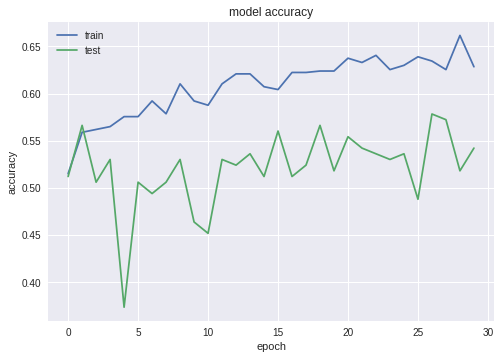

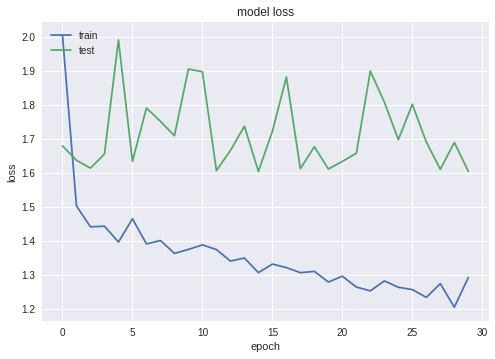

In [49]:
import matplotlib.pyplot as plt
import numpy

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.load_weights("weights.best.hdf5")
# Compile model (required to make predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [51]:
score = model.evaluate(x_val, y_val,
                       batch_size=32, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

206/206 [==============================] - 3s 17ms/step
Test score: 1.6050486032245228
Test accuracy: 0.5728155342699255


In [0]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [0]:
y_softmax = model.predict(x_val)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_val)):
    probs = y_val[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [54]:
print(y_test_1d)
print(y_pred_1d)

[0, 2, 1, 1, 2, 4, 4, 6, 6, 0, 0, 6, 5, 1, 1, 4, 7, 4, 0, 5, 4, 5, 6, 5, 2, 2, 6, 4, 4, 7, 3, 3, 4, 5, 0, 6, 6, 6, 7, 6, 0, 6, 6, 2, 2, 0, 2, 4, 3, 7, 3, 7, 2, 5, 2, 2, 4, 3, 4, 4, 6, 3, 7, 6, 4, 5, 6, 4, 6, 3, 6, 0, 5, 7, 2, 6, 6, 2, 7, 4, 6, 2, 0, 3, 2, 2, 2, 1, 3, 5, 7, 4, 3, 3, 3, 6, 7, 1, 4, 6, 6, 3, 2, 4, 7, 6, 5, 7, 5, 6, 0, 0, 6, 0, 5, 6, 4, 7, 1, 5, 0, 7, 7, 6, 4, 1, 5, 4, 2, 4, 5, 4, 4, 1, 0, 6, 6, 3, 3, 7, 7, 0, 0, 6, 6, 6, 0, 2, 4, 7, 7, 4, 4, 2, 2, 3, 2, 2, 7, 7, 3, 6, 4, 2, 4, 2, 4, 6, 3, 5, 7, 5, 2, 2, 4, 2, 4, 3, 3, 3, 0, 4, 3, 2, 3, 7, 7, 6, 0, 1, 7, 2, 7, 6, 0, 6, 6, 4, 6, 4, 2, 3, 0, 1, 4, 2]
[2, 2, 7, 7, 6, 2, 4, 6, 6, 4, 4, 6, 6, 7, 0, 4, 7, 7, 2, 6, 4, 6, 6, 6, 2, 4, 6, 4, 4, 7, 3, 0, 4, 6, 2, 4, 6, 6, 7, 4, 3, 6, 6, 4, 2, 7, 2, 2, 7, 7, 3, 7, 2, 6, 7, 2, 4, 0, 4, 4, 6, 3, 7, 4, 4, 6, 6, 4, 6, 3, 6, 2, 2, 7, 2, 6, 4, 2, 7, 2, 6, 2, 2, 7, 4, 2, 3, 4, 0, 6, 7, 4, 3, 3, 7, 6, 7, 7, 4, 6, 6, 2, 2, 4, 7, 6, 7, 7, 3, 6, 2, 2, 4, 3, 6, 6, 4, 7, 7, 6, 3, 7, 7, 6, 4, 7, 6,

## Prepare Labels and Specs for the model
In this part of the notebook, we will create three list. One contains the specs and the other two the labels for paths and for specs. The lists are later used as input for the actual preprocessing and then later the model.

In [68]:
labelsPath = list()
labelsStruct = list()


for labs in labelsS:
  labelsStruct.append(labs[1])

for labp in labelsP:
  labelsPath.append(labp[1])
  
print(str(len(labelsPath)))
print(str(len(labelsStruct)))

#labelsStruct = labelsS["cluster"].tolist()

1034
1034


In [69]:
print(labelsPath)
print(labelsStruct)

[1, 2, 3, 3, 1, 2, 1, 1, 3, 1, 2, 3, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 2, 2, 2, 3, 3, 1, 1, 3, 2, 3, 3, 3, 3, 3, 3, 1, 3, 2, 2, 2, 2, 2, 2, 1, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 2, 3, 3, 1, 1, 3, 3, 2, 3, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 1, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 3, 1, 1, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 2, 3, 2, 2, 3, 3, 3, 1, 1, 1, 3, 1, 2, 1, 1, 1, 2, 2, 3, 1, 1, 2, 3, 3, 2, 3, 3, 3, 2, 2, 1, 3, 2, 

### Create training and test split of the labels

In [0]:
Y_Path_train = labelsPath[:808]
Y_Path_test = labelsPath[808:]

Y_Struct_train = labelsStruct[:808]
Y_Struct_test = labelsStruct[808:]

In [71]:
print(len(Y_Path_train))
print(len(Y_Path_test))
print(len(Y_Struct_train))
print(len(Y_Struct_test))

808
226
808
226


In [0]:
with open('pickle/Y_Path_train.pickle', 'wb') as handle:
    pickle.dump(Y_Path_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
with open('pickle/Y_Path_test.pickle', 'wb') as handle:
    pickle.dump(Y_Path_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
with open('pickle/Y_Struct_train.pickle', 'wb') as handle:
    pickle.dump(Y_Struct_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
with open('pickle/Y_Struct_test.pickle', 'wb') as handle:
    pickle.dump(Y_Struct_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
specs_json = list()

In [0]:
import json

In [78]:
for spec in training_data:
  strJson = json.dumps(training_data[spec])
  specs_json.append(strJson)

print(str(len(specs_json)))
  
  

1034


In [79]:
specs_json[1]

'{"swagger": "2.0", "schemes": ["https"], "host": "6-dot-authentiqio.appspot.com", "basePath": "/", "info": {"contact": {"email": "hello@authentiq.com", "name": "Authentiq team", "url": "http://authentiq.io/support"}, "description": "Strong authentication, without the passwords.", "license": {"name": "Apache 2.0", "url": "http://www.apache.org/licenses/LICENSE-2.0.html"}, "termsOfService": "http://authentiq.com/terms/", "title": "Authentiq", "version": "6", "x-apisguru-categories": ["security"], "x-logo": {"backgroundColor": "#F26641", "url": "https://api.apis.guru/v2/cache/logo/https_www.authentiq.com_theme_images_authentiq-logo-a-inverse.svg"}, "x-origin": [{"format": "swagger", "url": "https://raw.githubusercontent.com/AuthentiqID/authentiq-docs/master/docs/swagger/issuer.yaml", "version": "2.0"}], "x-preferred": true, "x-providerName": "6-dot-authentiqio.appspot.com"}, "parameters": {"AuthentiqID": {"description": "Authentiq ID to register", "in": "body", "name": "body", "required"

In [82]:
X_train = specs_json[:808]
X_test = specs_json[808:]

print(len(X_train))
print(len(X_test))

808
226


## Preprocessing
In this part of the notebook we are going to preprocess the data itself. The data will be tokenized, preprocessed and stored as Training and Test sets

In [0]:
from keras.preprocessing.text import Tokenizer

Once fit, the Tokenizer provides 4 attributes that you can use to query what has been learned about your documents:

*   word_counts: A dictionary of words and their counts.
*   word_docs: A dictionary of words and how many documents each appeared in.
*   word_index: A dictionary of words and their uniquely assigned integers.
*   document_count:An integer count of the total number of documents that were used to fit the Tokenizer.


[source](https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/)


In [0]:
tokenizer = Tokenizer(num_words=100000,filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')

tokenizer

tokenizer.fit_on_texts(specs_json)



x_train = tokenizer.texts_to_matrix(X_train)
x_test = tokenizer.texts_to_matrix(X_test)

--------------------------------

In [84]:
x_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [85]:
x_test

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [0]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

encoder = LabelBinarizer()
encoder.fit(labelsStruct)
y_train = encoder.transform(Y_Struct_train)
y_test = encoder.transform(Y_Struct_test)

In [94]:
y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [95]:
len(x_train[0])

100000

In [96]:
print('y_train shape:', y_train.shape)

y_train shape: (808, 8)


In [97]:
print('x_train shape:', x_train.shape)

x_train shape: (808, 100000)


In [0]:
batch_size = 32
epochs = 2

---------------------------------------------------------------

## Model Architecture
In this section of the notebook the actual deep learning model is designed and the architecture presented before the actual training of it will take place.

In [0]:
model = Sequential()
model.add(Embedding(10000, 128, input_length=100000))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(8, activation='softmax',name = 'softmax_layer'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [114]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100000, 128)       1280000   
_________________________________________________________________
dropout_26 (Dropout)         (None, 100000, 128)       0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 99996, 64)         41024     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 24999, 64)         0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 24999, 64)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
__________

In [0]:
history = model.fit(x_train, y_train,
                    batch_size=8,
                    epochs=3,
                    verbose=1,
                    validation_split=0.2)

Train on 646 samples, validate on 162 samples
Epoch 1/3
  8/646 [..............................] - ETA: 1:48:40 - loss: 2.0601 - acc: 0.3750

In [0]:
model2 = Sequential()
model2.add(Dense(2048, input_shape=(100000,), activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1024, activation='sigmoid'))
model2.add(Dropout(0.2))
model2.add(Dense(8, activation='softmax'))

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [110]:
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 2048)              204802048 
_________________________________________________________________
dropout_21 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_22 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 8200      
Total params: 206,908,424
Trainable params: 206,908,424
Non-trainable params: 0
_________________________________________________________________
None


In [111]:
history2 = model2.fit(x_train, y_train,
                    batch_size=32,
                    epochs=15,
                    verbose=1,
                    validation_split=0.2)

Train on 646 samples, validate on 162 samples
Epoch 1/15
646/646 [==============================] - 8s 13ms/step - loss: 0.9245 - acc: 0.6827 - val_loss: 5.2256 - val_acc: 0.0617
Epoch 2/15
646/646 [==============================] - 6s 9ms/step - loss: 0.1744 - acc: 0.9474 - val_loss: 3.4736 - val_acc: 0.0864
Epoch 3/15
646/646 [==============================] - 6s 9ms/step - loss: 0.0292 - acc: 0.9938 - val_loss: 3.0794 - val_acc: 0.0802
Epoch 4/15
646/646 [==============================] - 6s 9ms/step - loss: 0.0120 - acc: 0.9985 - val_loss: 3.2029 - val_acc: 0.0988
Epoch 5/15
 64/646 [=>............................] - ETA: 4s - loss: 0.0052 - acc: 1.0000

KeyboardInterrupt: ignored

### first training

In [0]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [0]:
score = model2.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

In [0]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=128)


In [0]:
loss_and_metrics = model2.evaluate(x_test, y_test, batch_size=128)


### Use Model

In [0]:
classes = model.predict(x_test, batch_size=128)


In [0]:
classes2 = model2.predict(x_test, batch_size=128)

### Evaluation

In [0]:
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_posts.iloc[i][:50], "...")
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

In [0]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [0]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()